Module 3 Final Project Submission / Noah X. Deutsch (Self-Paced)

# Predicting The Success of Kickstarters

## Project Overview
For this project, I set out to answer the following question: Can we use supervised learning to predict the success of a kickstarter project before it even launches? Working with a Kaggle dataset, I explored explored and optimized a range of classification models to approach this question.


## My Approach
### Obtain Data √
- From Kaggle

### Scrub √
- Creating our predictor variables
- Normalizing our data
- Train test split

### Model, Compare, and Refine √
- Fit baseline models
- Compare results
- Optimize models wih GridSearch
- Compare results

### Interpret √
- Draw conclusions


---
## Obtain

Original dataset:
https://www.kaggle.com/kemical/kickstarter-projects?select=ks-projects-201801.csv

In [1]:
#Import neccessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#Loading in our data set

ksdf = pd.read_csv('ks-projects-201801.csv')
ksdf.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [3]:
#Looking at our shape
ksdf.shape

(378661, 15)

In [4]:
#and value counts for our Y variable
ksdf.state.value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

---
## Scrub √
- Creating our predictor variables
- Normalizing our data
- Train test split

In [5]:
#Let's start by simplifying our "State" column

ksdf["state"].replace({"suspended": "failed", "canceled": "failed"}, inplace=True)
ksdf = ksdf.loc[ksdf["state"] != 'undefined']
ksdf = ksdf.loc[ksdf["state"] != 'live']

ksdf.state.value_counts()

failed        238344
successful    133956
Name: state, dtype: int64

In [6]:
#We still have a crazy number of rows. 
#Let's reduce this to a more managable number so my computer can actually run the models...

ksdf = ksdf.sample(n=50000,random_state=1)
ksdf.shape

(50000, 15)

In [7]:
#Sepparating our data into our X and Y for future modeling. 

y = ksdf['state']
x = ksdf.drop(['state'],axis = 1)

In [8]:
#Selecting from X the predictor columns we want. 
#Columns like "backers" & "usd pledged" we'll leave out, because they are things that would be known ahead of time.

x1 = x[['category','main_category','currency','goal','country']]

In [9]:
#Let's make use of our date information, and add a column that represents the length of a Kickstarter project.

import datetime as dt

x['deadline']= pd.to_datetime(x['deadline']) 
x['launched']= pd.to_datetime(x['launched']) 

x1['Days_btw_launch_&_deadline'] = (x['deadline'] - x['launched']).dt.days
x1.head()

/Users/noahxdeutsch/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,category,main_category,currency,goal,country,Days_btw_launch_&_deadline
28550,Fashion,Fashion,USD,2500.0,US,29
206859,Fiction,Publishing,USD,18036.0,US,39
340059,Music,Music,USD,12000.0,US,29
224065,Fiction,Publishing,USD,2000.0,US,22
161757,Fiction,Publishing,USD,3570.0,US,59


In [10]:
#Let's add another column that indicates which month the project launched.
x1['launch_month'] = x['launched'].dt.month

#and make it a string so it's one hot encoded later
x1['launch_month'] = x1['launch_month'].astype(str)
x1.dtypes


/Users/noahxdeutsch/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/noahxdeutsch/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


category                       object
main_category                  object
currency                       object
goal                          float64
country                        object
Days_btw_launch_&_deadline      int64
launch_month                   object
dtype: object

In [11]:
#without getting too crazy into NLP world....
#Let's add a column for number of words in the project name
x1['words_in_name'] = ksdf['name'].str.split().str.len()
x1.head()

/Users/noahxdeutsch/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,category,main_category,currency,goal,country,Days_btw_launch_&_deadline,launch_month,words_in_name
28550,Fashion,Fashion,USD,2500.0,US,29,2,7
206859,Fiction,Publishing,USD,18036.0,US,39,7,11
340059,Music,Music,USD,12000.0,US,29,10,7
224065,Fiction,Publishing,USD,2000.0,US,22,3,7
161757,Fiction,Publishing,USD,3570.0,US,59,4,12


In [12]:
#Lastly, let's look at the most common words in project names for our successful and failed groups

ksdf.name = ksdf.name.str.lower()

from collections import Counter
sWords = Counter(" ".join(ksdf.loc[ksdf["state"] == 'successful']["name"]).split()).most_common(200)

fWords = Counter(" ".join(ksdf.loc[ksdf["state"] == 'failed']["name"]).split()).most_common(200)

print(sWords)
print('\n')
print(fWords)        

[('the', 5294), ('-', 2953), ('a', 2823), ('of', 1879), ('and', 1215), ('for', 1131), ('to', 994), ('&', 971), ('new', 929), ('in', 928), ('album', 762), ('film', 709), ('by', 641), ('project', 519), ('book', 475), ('short', 428), ('an', 412), ('your', 401), ('art', 399), ('game', 388), ('first', 381), ('with', 371), ('debut', 362), ('on', 356), ('music', 332), ('help', 325), ('from', 284), ('at', 266), ('is', 247), ('ep', 238), ('documentary', 226), ('|', 219), ('you', 215), ('my', 214), ('cards', 174), ('tour', 172), ('love', 171), ('one', 170), ('make', 165), ('series', 163), ('video', 160), ('album!', 157), ('i', 156), ('life', 155), ('our', 153), ('festival', 151), ('card', 150), ('about', 149), ('world', 146), ('record', 145), ('cd', 142), ('2', 138), ('get', 136), ('show', 135), ('novel', 132), ('playing', 132), ('"the', 131), ('studio', 126), ('edition', 125), ('1', 124), ('+', 123), ('story', 123), ('me', 122), ('dance', 120), ('be', 118), (':', 116), ('recording', 115), ('it'

In [13]:
#A quick function for getting us the words that are in sWords, but not in fWords

uniquewords = []
for word in sWords:
    status = 0
    for word2 in fWords:
        if word[0] == word2[0]:
            status = 1
    if status != 1:
        uniquewords.append(word[0])

uniquewords

['album!',
 'issue',
 'enamel',
 'dice',
 'presents',
 'length',
 'season',
 'wallet',
 'their',
 '2015',
 'watch',
 '–',
 'theatre',
 'volume',
 '2014',
 'solo',
 'graphic',
 'band',
 'two',
 'night',
 '2013',
 'exhibition',
 '2012',
 'red',
 'leather',
 '#1',
 'burning',
 'dead',
 'lost',
 'full-length',
 'performance',
 'most',
 'pin',
 'year',
 'second',
 'pins',
 '2016',
 'project:',
 '2017',
 '--',
 'her',
 'living',
 'like',
 'wild',
 'women',
 'deck',
 'street',
 'his']

In [14]:
#The inverse of the above

uniquewords1 = []
for word in fWords:
    status = 0
    for word2 in sWords:
        if word[0] == word2[0]:
            status = 1
    if status != 1:
        uniquewords1.append(word[0])

uniquewords1 = uniquewords1[1:]

uniquewords1

['app',
 'clothing',
 'mobile',
 'social',
 'apparel',
 'fashion',
 'dream',
 'real',
 'system',
 '(suspended)',
 'family',
 'people',
 'needs',
 'online',
 'custom',
 'iphone',
 'truck',
 'tv',
 'case',
 'launch',
 'production',
 'can',
 'war',
 'web',
 'games',
 'road',
 'what',
 'future',
 'school',
 'organic',
 'travel',
 'open',
 'line',
 'box',
 'power',
 'gaming',
 'go',
 'adventures',
 'business',
 'will',
 'just',
 'hand',
 'party',
 'unique',
 'do',
 'artist',
 'true']

In [15]:
#adding columns to our X for each word

orig_length = len(x1.columns)

for word in uniquewords:
    label = 'contains_'+str(word)
    x1[label] = [1 if word in x else 0 for x in ksdf['name']]

for word in uniquewords1:
    label = 'contains_'+str(word)
    x1[label] = [1 if word in x else 0 for x in ksdf['name']]
    
print(orig_length, 'to ->', len(x1.columns))
x1.describe()

/Users/noahxdeutsch/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


8 to -> 103


,goal,Days_btw_launch_&_deadline,words_in_name,contains_album!,contains_issue,contains_enamel,contains_dice,contains_presents,contains_length,contains_season,...,contains_adventures,contains_business,contains_will,contains_just,contains_hand,contains_party,contains_unique,contains_do,contains_artist,contains_true
count,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.588778e+04,33.562980,5.692980,0.005000,0.003900,0.002740,0.003040,0.004480,0.004920,0.004340,...,0.002960,0.002760,0.004160,0.004360,0.011580,0.003200,0.002960,0.058260,0.005520,0.002800
std,1.425785e+06,75.796409,2.763011,0.070534,0.062329,0.052274,0.055053,0.066783,0.069971,0.065736,...,0.054326,0.052464,0.064364,0.065887,0.106987,0.056479,0.054326,0.234237,0.074092,0.052841
min,1.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000e+03,29.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.500000e+03,29.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.650000e+04,36.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000e+08,16738.000000,21.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
#Great. Let's take a look at our Y column
y.head()

28550         failed
206859        failed
340059    successful
224065        failed
161757        failed
Name: state, dtype: object

In [17]:
#Let's label encode our Y

from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)
y = pd.DataFrame(y)
y.head()

,0
0,0
1,0
2,1
3,0
4,0


In [18]:
#And finally, let's get dummies for the non continuous variables in our X

x2 = pd.get_dummies(x1)
print(x2.shape)
x2.columns

(50000, 321)


Index(['goal', 'Days_btw_launch_&_deadline', 'words_in_name',
       'contains_album!', 'contains_issue', 'contains_enamel', 'contains_dice',
       'contains_presents', 'contains_length', 'contains_season',
       ...
       'launch_month_11', 'launch_month_12', 'launch_month_2',
       'launch_month_3', 'launch_month_4', 'launch_month_5', 'launch_month_6',
       'launch_month_7', 'launch_month_8', 'launch_month_9'],
      dtype='object', length=321)

In [19]:
#Looks good!
#Now let's normalize our data.

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

x3 = scaler.fit_transform(x2)

pd.DataFrame(x3).describe()

/Users/noahxdeutsch/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,0,1,2,3,4,5,6,7,8,9,...,311,312,313,314,315,316,317,318,319,320
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000
mean,0.000559,0.002005,0.234649,0.005000,0.003900,0.002740,0.003040,0.004480,0.004920,0.004340,...,0.084900,0.056380,0.076360,0.092140,0.087420,0.088440,0.085980,0.09664,0.084800,0.083940
std,0.014258,0.004528,0.138151,0.070534,0.062329,0.052274,0.055053,0.066783,0.069971,0.065736,...,0.278736,0.230656,0.265576,0.289226,0.282452,0.283937,0.280337,0.29547,0.278587,0.277301
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000020,0.001733,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,0.000055,0.001733,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,0.000165,0.002151,0.350000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [20]:
#Great! And lastly, let's create our train test splits.

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x3, y, stratify=y,random_state=0)

*Newly Added

# Exploritory Analysis

In [21]:
#Before jumping into modeling, let's take a look at some of our columns

x1.columns[0:8]

Index(['category', 'main_category', 'currency', 'goal', 'country',
       'Days_btw_launch_&_deadline', 'launch_month', 'words_in_name'],
      dtype='object')

In [78]:
x_eda = x1

x_eda['y'] = y*100

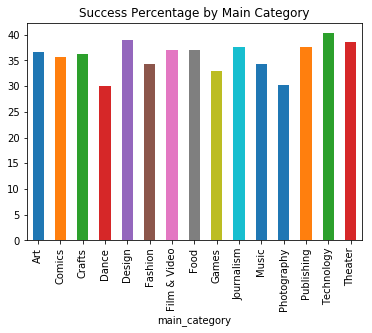

In [105]:
x_eda.groupby('main_category').mean().plot(y='y',kind='bar',legend=False,title='Success Percentage by Main Category')

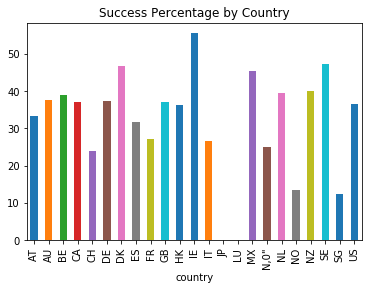

In [104]:
x_eda.groupby('country').mean().plot(y='PercentSuccessful',kind='bar',legend=False,title='Success Percentage by Country')

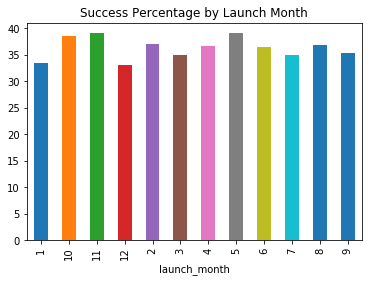

In [102]:
x_eda.groupby('launch_month').mean().plot(y='y',kind='bar',legend=False,title='Success Percentage by Launch Month')

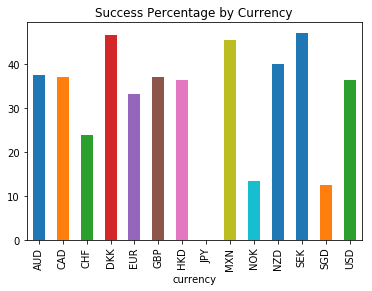

In [106]:
x_eda.groupby('currency').mean().plot(y='y',kind='bar',legend=False,title='Success Percentage by Currency')

(array([6.6310e+03, 1.2505e+04, 1.1512e+04, 1.0365e+04, 6.8910e+03,
        1.8310e+03, 2.1200e+02, 4.4000e+01, 8.0000e+00, 1.0000e+00]),
 array([ 1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19., 21.]),
 <a list of 10 Patch objects>)

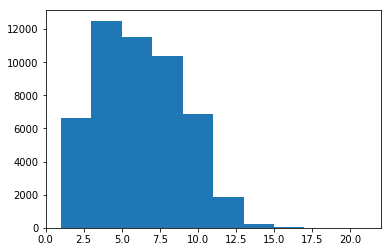

In [110]:
plt.hist(x1['words_in_name'])

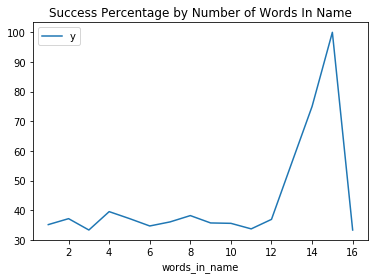

In [107]:
x_eda.groupby('words_in_name').mean().plot(y='y',title='Success Percentage by Number of Words In Name')

In [101]:
#Takeaways

#Plenty of subtle differences in outcome exist for each feature, but nothing too dramatic
#Some of the data (such as 'wordsinname') looks weird because there are very few samples at the tail end
#By combining these small differences, we can hopefully produce a model that can predict success with some accuracy!

---
## Model, Compare, and Refine √
- Fit baseline models
- Compare results
- Optimize models wih GridSearch
- Compare results

In [ ]:
#Importing for our modeling!

from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import LinearSVC
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' #This fixes a bug in XGB that crashes the Kernel
import xgboost as xgb

from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

import itertools
from sklearn.metrics import confusion_matrix

In [ ]:
#Create a dictionary for holding results

model_comparison = {}

### Baseline Models

In [ ]:
#Baseline Decision Tree

dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)
training_preds = dt_clf.predict(X_train)
val_preds = dt_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

model_comparison['Baseline DT'] = [round(training_accuracy,4),round(val_accuracy,4)]

In [ ]:
#Baseline RandomForrest

rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
training_preds = rf_clf.predict(X_train)
val_preds = rf_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

model_comparison['Baseline RForrest'] = [round(training_accuracy,4),round(val_accuracy,4)]

In [ ]:
#Baseline AdaBoost

ab_clf = AdaBoostClassifier()
ab_clf.fit(X_train, y_train)
training_preds = ab_clf.predict(X_train)
val_preds = ab_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

model_comparison['Baseline AdaBoost'] = [round(training_accuracy,4),round(val_accuracy,4)]

In [ ]:
#Baseline Linear SVC

svc_clf = LinearSVC()
svc_clf.fit(X_train, y_train)
training_preds = svc_clf.predict(X_train)
val_preds = svc_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

model_comparison['Baseline LinearSVC'] = [round(training_accuracy,4),round(val_accuracy,4)]

In [ ]:
#Baseline XGBoost

xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)
training_preds = xgb_clf.predict(X_train)
val_preds = xgb_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

model_comparison['Baseline XGB'] = [round(training_accuracy,4),round(val_accuracy,4)]

### Baseline Model Comparison

In [ ]:
model_comparison

In [ ]:
#plotting our comparison values

mod_name = []
train_a = []
test_a = []
for mod in model_comparison.keys():
    mod_name.append(mod)
    
for mod in model_comparison.values():
    train_a.append(mod[0])
    test_a.append(mod[1])

    
fig, ax  = plt.subplots(figsize = (12,6))

ax.set_ylim([.5, 1],auto=False)    

ax.bar(mod_name,train_a,label='Training Data Accuracy',align='edge',width = -0.3, linewidth = 1,edgecolor = 'black')
ax.bar(mod_name,test_a,color='lightblue',label='Test Data Accuracy',align='edge',width = 0.3,linewidth = 1,edgecolor = 'black')

plt.title('Comparing Baseline Classification Model Accuracy',fontsize = 20)
ax.legend(loc='upper right')

In [ ]:
#Observations ––––––––
    #Clearly, our decision tree and random forrest are overfitting
    #All of our classification models performed similarly on the Test Data (between 60-70%)
    #Best performing were Adaboost, Linear SVC and XGboost. All performed very similarly. 
    #None of the models performed terribly well.. as 50% performance is as good as random guessing.
    #Still, this is a significant improvement on random guessing.

#let's see what we can improve with gridsearch! 
#We'll focus on our top 3 models. 

### Model Refinement

In [ ]:
#Grid Search for AdaBoost

param_grid = {
    'learning_rate':[.1,1],
    "n_estimators": [50,500],
    'random_state': [0]
}

grid_clf = GridSearchCV(ab_clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
val_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

model_comparison['Optimized AdaBoost'] = [round(training_accuracy,4),round(val_accuracy,4)]

In [ ]:
#Confusion Matrix for Adaboost

cnf_matrix = confusion_matrix(val_preds, y_test)
plt.imshow(cnf_matrix,  cmap=plt.cm.Blues) #Create the basic matrix.

#Add title and Axis Labels
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

#Add appropriate Axis Scales
class_names = ['Fail','Success'] #Get class labels to add to matrix
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)


#Add Labels to Each Cell
thresh = cnf_matrix.max() / 2. #Used for text coloring below
#Here we iterate through the confusion matrix and append labels to our visualization.
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

plt.colorbar()

In [ ]:
#Grid Search for Linear SVC

param_grid = {
    'loss': ['hinge', 'squared_hinge'],
    'C': [1,20],
}

grid_clf = GridSearchCV(svc_clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
val_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

model_comparison['Optimized LinearSVC'] = [round(training_accuracy,4),round(val_accuracy,4)]

In [ ]:
#Confusion Matrix for Linear SVC

cnf_matrix = confusion_matrix(val_preds, y_test)
plt.imshow(cnf_matrix,  cmap=plt.cm.Blues) #Create the basic matrix.

#Add title and Axis Labels
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

#Add appropriate Axis Scales
class_names = ['Fail','Success'] #Get class labels to add to matrix
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

#Add Labels to Each Cell
thresh = cnf_matrix.max() / 2. #Used for text coloring below
#Here we iterate through the confusion matrix and append labels to our visualization.
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

plt.colorbar()

In [ ]:
#Grid Search for XGBoost

param_grid = {
    "learning_rate": [.1,1], 
    "n_estimators": [100,250], # default 100
}

grid_clf = GridSearchCV(xgb_clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
val_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

model_comparison['Optimized XGBoost'] = [round(training_accuracy,4),round(val_accuracy,4)]

In [ ]:
#Confusion Matrix for XGBoost

cnf_matrix = confusion_matrix(val_preds, y_test)
plt.imshow(cnf_matrix,  cmap=plt.cm.Blues) #Create the basic matrix.

#Add title and Axis Labels
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

#Add appropriate Axis Scales
class_names = ['Fail','Success'] #Get class labels to add to matrix
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

#Add Labels to Each Cell
thresh = cnf_matrix.max() / 2. #Used for text coloring below
#Here we iterate through the confusion matrix and append labels to our visualization.
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

plt.colorbar()

## Interpretation

In [ ]:
model_comparison

In [ ]:
#Final Comparison

mod_name = []
train_a = []
test_a = []
for mod in model_comparison.keys():
    mod_name.append(mod)
    
for mod in model_comparison.values():
    train_a.append(mod[0])
    test_a.append(mod[1])

    
fig, ax  = plt.subplots(figsize = (12,6))

ax.set_ylim([.68, .73],auto=False)    

ax.bar(mod_name[2:],train_a[2:],label='Training Data Accuracy',align='edge',width = -0.3, linewidth = 1,edgecolor = 'black')
ax.bar(mod_name[2:],test_a[2:],color='lightblue',label='Test Data Accuracy',align='edge',width = 0.3,linewidth = 1,edgecolor = 'black')

plt.title('Comparing Classification Model Accuracy',fontsize = 20)
ax.legend(loc='upper right')

---
## Interpret

### Ultimately, our Adaboost classifier performed the best, with a **Train Accuracy of 71.48%** and a **Test accuracy of 70.26%**

The classifier was able to classify ~62% of successes correctly and ~74% of failures correctly. 

While this is a significant improvement over random guessing (50%) – it still is far from perfect, with plenty of false positives and negatives.

Attempts to build a superior model would benefit from additional project-level data, including data points like product pricing and tiers, full project descriptions, creator bios, and more.